In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables


/var/folders/gd/1rc7r2f97g9765_pvtcth22h0000gn/T/ipykernel_43428/3559592862.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [23]:
# View all of the classes that automap found
for class_name in Base.classes.keys():
    print(f"Found class: {class_name}")

Found class: measurement
Found class: station


In [24]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

print("\nIndividual variables:")
print(f"Station: {Station}")
print(f"Measurement: {Measurement}")



Individual variables:
Station: <class 'sqlalchemy.ext.automap.station'>
Measurement: <class 'sqlalchemy.ext.automap.measurement'>


In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

stations = session.query(Station).all()
for station in stations:
    print(station.id, station.name)

1 WAIKIKI 717.2, HI US
2 KANEOHE 838.1, HI US
3 KUALOA RANCH HEADQUARTERS 886.9, HI US
4 PEARL CITY, HI US
5 UPPER WAHIAWA 874.3, HI US
6 WAIMANALO EXPERIMENTAL FARM, HI US
7 WAIHEE 837.5, HI US
8 HONOLULU OBSERVATORY 702.2, HI US
9 MANOA LYON ARBO 785.2, HI US


# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
print(most_recent_date)

2017-08-23 00:00:00


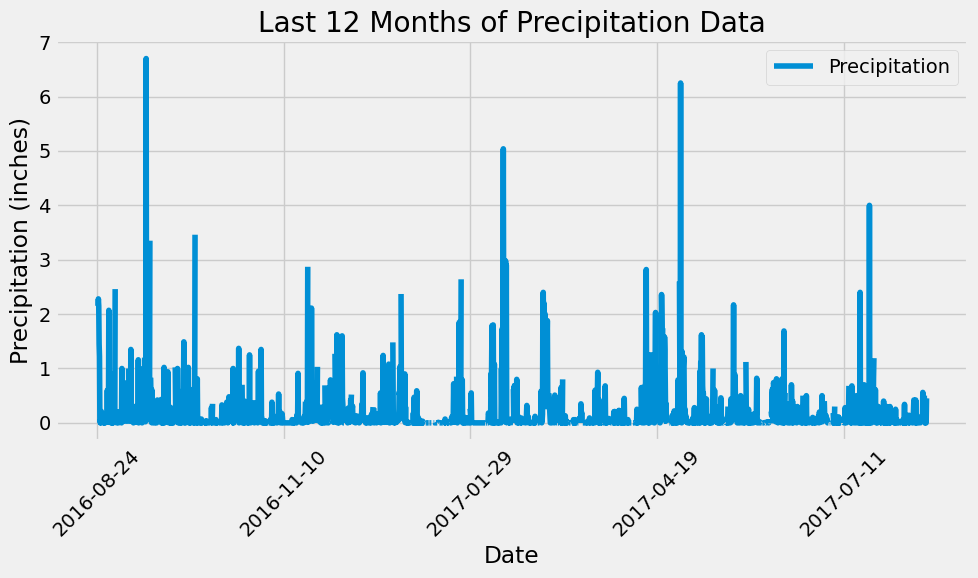

In [29]:
from datetime import timedelta
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', kind='line', figsize=(10, 6), rot=45)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.tight_layout()
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


In [34]:
df.tail()

,Date,Precipitation
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00
2222,2017-08-23,0.45


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station.distinct())).scalar()
print(total_stations)

9


In [36]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station, func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Print the result
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(
    func.min(Measurement.tobs).label("min_temp"),
    func.max(Measurement.tobs).label("max_temp"),
    func.avg(Measurement.tobs).label("avg_temp")
).filter(Measurement.station == most_active_station_id).one()

# Print results
print(f"Most Active Station: {most_active_station_id}")
print(f"Lowest Temperature: {temperature_stats.min_temp}°F")
print(f"Highest Temperature: {temperature_stats.max_temp}°F")
print(f"Average Temperature: {temperature_stats.avg_temp:.2f}°F")


Most Active Station: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


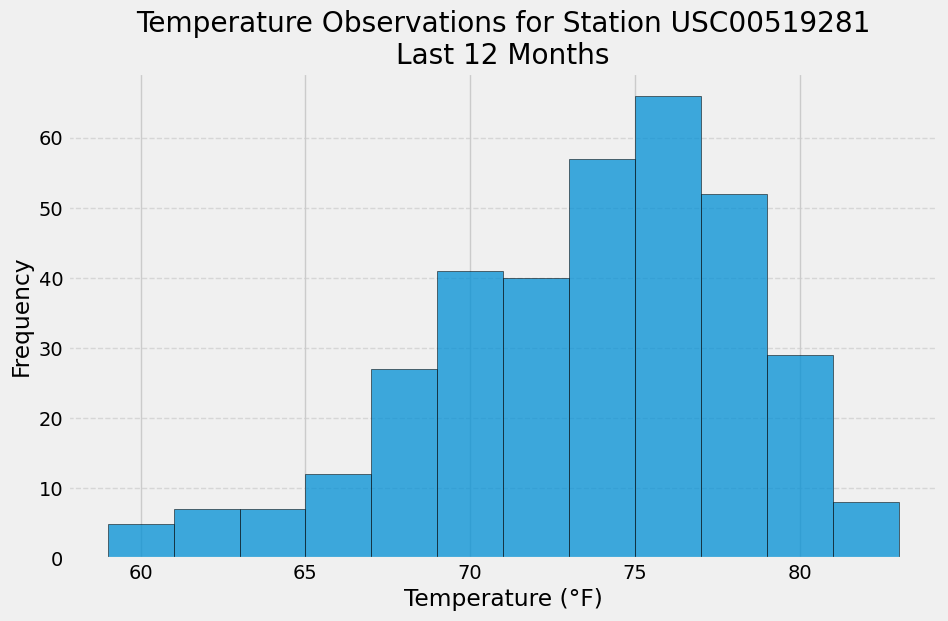

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= one_year_ago
).all()

# Convert query results to Pandas DataFrame
df = pd.DataFrame(temp_data, columns=["date", "temperature"])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df["temperature"], bins=12, edgecolor="black", alpha=0.75)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for Station {most_active_station_id}\nLast 12 Months")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Close Session

In [39]:
# Close Session
session.close()